# Module_1: 

## Team Members:
Andrea Perez 

## Project Title:

**Identifying relationships between cognitive performance and neuropathology in Alzheimer’s disease**


## Project Goal:

This project asks: (1) do microinfarct counts differ between cognitively resilient and non-resilient donors with high AD pathology, and (2) is cognition (MMSE) related to Braak stage?



Questions asked that won't be pursued:
1. How much is the brain tissue affected? (CERAD score, Overall CAA Score, Highest Lewy Body Disease)
2. Leading cause of death? (Clinical consensus Dx)
3. Do lesion tests match cognitive scores?
4. Can we predict cognitive status from scores? (Braak, Cerad, vascular,...)

Question that inspire the goal of this project:

5. Can we show the trends in patients who maintained cognitive status intact despite the pathology in the brain?

## Disease Background: 

https://docs.google.com/document/d/1KwX8_tScE6G5rayo1ox_byvlld-LcJhhona93Ks_NH0/edit?usp=sharing



## Data-Set: 

Source:
https://doi.org/10.1038/s41593-024-01774-5
- Received 24 April 2024, accepted 28 August 2024, published October 2024.
- Focused on understanding AD at the cellular level
- Techniques applied: snRNA-seq, snATAC-seq, MERFISH (spatial transcriptomics), Immunohistochemistry (IHC).
- Studied middle temporal gyrus brain tissue (collected post-mortem) from 84 human donors with varying severity of Alzheimer’s disease pathology
- 33 male donors, 51 female. Ages 65 to 102 years, mean ~88 years. Majority of European descent. 
- Donors span the full spectrum of Alzheimer’s disease pathology
- Excluded cases with confounding disorders 
- Defined a “disease pseudoprogression score” (CPS)
- Biases: over-representation of females, predominantly White, non-random sampling, researchers were not fully blinded.
- Limitations/Assumptions: samples don't reflect living brain tissue, captured AD effects only from prefrontal cortex, some "low-quality" nuclei were excluded, limited demographic diversity




## Data Analyis: 

Goal: 

Within high-pathology donors (Braak ≥ 5 and Thal ≥ 4), define two cognitive groups:
Resilient (MMSE ≥ 24 or MOCA ≥ 26) vs Non-Resilient. Compare vascular burden between these groups using Total Microinfarcts. Relate pathology to cognition by plotting MMSE vs Braak with a fitted line and reporting R²

- Null Hypothesis: The mean of total microinfarcts is the same in resilient and non-resilient donors.
- Alternate Hypothesis: The mean total microinfarcts is different between groups.

In [30]:
#importing libraries
import re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, linregress

# setting display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 40)


In [31]:
#loading the 2 CSV files
META_CSV = "UpdatedMetaData.csv"       
LUMINEX_CSV = "UpdatedLuminex.csv"  

#checking if the file we will use loaded correctly / describing rows and columns
df = pd.read_csv(META_CSV)
print("Shape:", df.shape)
df.head(3)


Shape: (84, 66)


,Donor ID,Primary Study Name,Secondary Study Name,Age at Death,Sex,Race (choice=White),Race (choice=Black/ African American),Race (choice=Asian),Race (choice=American Indian/ Alaska Native),Race (choice=Native Hawaiian or Pacific Islander),Race (choice=Unknown or unreported),Race (choice=Other),specify other race,Hispanic/Latino,Highest level of education,Years of education,APOE Genotype,Cognitive Status,Age of onset cognitive symptoms,Age of Dementia diagnosis,Known head injury,Have they had neuroimaging,Consensus Clinical Dx (choice=Alzheimers disease),Consensus Clinical Dx (choice=Alzheimers Possible/ Probable),Consensus Clinical Dx (choice=Ataxia),Consensus Clinical Dx (choice=Corticobasal Degeneration),Consensus Clinical Dx (choice=Control),Consensus Clinical Dx (choice=Dementia with Lewy Bodies/ Lewy Body Disease),Consensus Clinical Dx (choice=Frontotemporal lobar degeneration),Consensus Clinical Dx (choice=Huntingtons disease),Consensus Clinical Dx (choice=Motor Neuron disease),Consensus Clinical Dx (choice=Multiple System Atrophy),Consensus Clinical Dx (choice=Parkinsons disease),Consensus Clinical Dx (choice=Parkinsons Cognitive Impairment - no dementia),Consensus Clinical Dx (choice=Parkinsons Disease Dementia),Consensus Clinical Dx (choice=Prion),Consensus Clinical Dx (choice=Progressive Supranuclear Palsy),Consensus Clinical Dx (choice=Taupathy),Consensus Clinical Dx (choice=Vascular Dementia),Consensus Clinical Dx (choice=Unknown),Consensus Clinical Dx (choice=Other),"If other Consensus dx, describe",Last CASI Score,Interval from last CASI in months,Last MMSE Score,Interval from last MMSE in months,Last MOCA Score,Interval from last MOCA in months,PMI,Rapid Frozen Tissue Type,Ex Vivo Imaging,Fresh Brain Weight,Brain pH,Overall AD neuropathological Change,Thal,Braak,CERAD score,Overall CAA Score,Highest Lewy Body Disease,Total Microinfarcts (not observed grossly),Total microinfarcts in screening sections,Atherosclerosis,Arteriolosclerosis,LATE,RIN,Severely Affected Donor
0,H19.33.004,ACT,NaN,80,Female,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,No,Bachelors,17,3-Mar,No dementia,NaN,NaN,NaN,Unknown,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,85.0,3.5,25.0,3.5,NaN,NaN,8.13,Precision Slices,Yes,1035,7.0,Not AD,Thal 0,Braak IV,Absent,Not identified,Not Identified (olfactory bulb not a...,1,1,Mild,Moderate,Not Identified,8.33,NaN
1,H20.33.001,ACT,NaN,82,Male,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,No,Bachelors,16,3-Mar,No dementia,NaN,NaN,NaN,Yes,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,97.0,18.2,28.0,18.2,NaN,NaN,7.70,Precision Slices,Yes,1338,6.8,Low,Thal 2,Braak IV,Sparse,Not identified,Not Identified (olfactory bulb not a...,0,0,Mild,Mild,LATE Stage 2,8.60,NaN
2,H20.33.002,ACT,NaN,97,Female,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,No,High School,12,3-Feb,No dementia,NaN,NaN,NaN,Unknown,Unchecked,Unchecked,Unchecked,Unchecked,Checked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,NaN,93.0,46.1,33.0,22.6,NaN,NaN,4.33,Precision Slices,Yes,1078,7.3,Not AD,Thal 0,Braak IV,Absent,Not identified,Limbic (Transitional),0,0,Moderate,Moderate,LATE Stage 2,7.87,NaN


In [32]:
# Creating Patient objects

from dataclasses import dataclass
from math import isnan

@dataclass
class Patient:
    donor_id: str | int | None
    age_at_death: float | None
    sex: str | None
    braak: float | None
    thal: float | None
    mmse: float | None
    moca: float | None
    microinfarcts: float | None
    resilient: bool

    @classmethod
    def from_row(cls, row):
        donor_id = row.get("donor ID") if "donor ID" in row else row.get("Donor ID")
        age = row.get("Age at death")
        sex = row.get("gender")
        braak = row.get("_Braak_num")
        thal  = row.get("_Thal_num")
        mmse  = row.get("Last MMSE Score") 
        moca  = row.get("Last MOCA Score") 
        micro = row.get("Total Microinfarcts (not observed grossly)") 
        resilient = bool(row.get("_Resilient", 0))
        return cls(donor_id, age, sex, braak, thal, mmse, moca, micro, resilient)

# Building the list of Patient objects
patients = [Patient.from_row(r) for _, r in df.iterrows()]


print("Total Patient objects:", len(patients))

# I worked directly with pandas DataFrames, so I will not use Patient objects moving forward


Total Patient objects: 84


In [39]:

BRAAK_COL = "Braak"
THAL_COL  = "Thal"

#parsing Braak and Thal into numbers

_ROMAN = {"I":1,"II":2,"III":3,"IV":4,"V":5,"VI":6}
def parse_braak(value):
    if pd.isna(value): return np.nan
    s = str(value).strip().upper()
    tokens = re.findall(r"(VI|IV|V|III|II|I|\d+)", s)
    if not tokens: return np.nan
    t = tokens[-1]
    if t in _ROMAN: return _ROMAN[t]
    try: return int(t)
    except: return np.nan

def parse_thal(value):
    if pd.isna(value): return np.nan
    s = str(value).strip().upper()
    m = re.search(r"(\d+)", s)
    return int(m.group(1)) if m else np.nan

df["Braak_num"] = df[BRAAK_COL].apply(parse_braak)
df["Thal_num"]  = df[THAL_COL].apply(parse_thal)


#these helpers standardize our data



1. We will define:
- High pathology = Braak ≥ 5 and Thal ≥ 4.
- Cognition intact = MMSE ≥ 24 or MOCA ≥ 26.
- Resilient = high pathology AND intact cognition.
- Non-Resilient = high pathology AND impaired cognition.

**
- _Resilient is 1 if High_Pathology == 1 AND Cognition_Intact == 1.
- _NonResilient is 1 if High_Pathology == 1 AND Cognition_Intact == 0.

This defines the two groups for the bar plot and t-test. *The table is a small preview

In [42]:

# Parsing to numeric and storing in new columns
df["_Braak_num"] = df[braak_col].apply(parse_braak)
df["_Thal_num"]  = df[thal_col].apply(parse_thal)

# flag cognitive status
mmse_ok = (df[mmse_col] >= 24) if mmse_col else pd.Series(False, index=df.index)
moca_ok = (df[moca_col] >= 26) if moca_col else pd.Series(False, index=df.index)
df["_Cognition_Intact"] = (mmse_ok | moca_ok).astype(int)

# defining pathology and resilient groups
df["_High_Pathology"] = ((df["_Braak_num"] >= 5) & (df["_Thal_num"] >= 4)).astype(int)
df["_Resilient"]      = ((df["_High_Pathology"] == 1) & (df["_Cognition_Intact"] == 1)).astype(int)
df["_NonResilient"]   = ((df["_High_Pathology"] == 1) & (df["_Cognition_Intact"] == 0)).astype(int)

print("Resilient:", int(df["_Resilient"].sum()))
print("Non-Resilient:", int(df["_NonResilient"].sum()))
df.loc[df["_High_Pathology"]==1, ["_Braak_num","_Thal_num","_Cognition_Intact","_Resilient","_NonResilient"]].head(8)


Resilient: 17
Non-Resilient: 26


,_Braak_num,_Thal_num,_Cognition_Intact,_Resilient,_NonResilient
3,5,5,1,1,0
5,5,4,1,1,0
6,5,5,0,0,1
12,6,4,0,0,1
13,6,5,0,0,1
15,6,5,0,0,1
16,5,4,1,1,0
17,5,4,0,0,1


2. We will compare groups on Total Microinfarcts (vascular burden)

this segment looks only for the microinfarcts column (two common header variants), converts values to numeric and drops missing rows.

In [50]:

MICRO_COL_CANDS = [
    "Total Microinfarcts (not observed grossly)"]

# pulling values for each group and removing invalid entries
res_vals = pd.to_numeric(df.loc[df["_Resilient"] == 1, comp_col], errors="coerce").dropna()
non_vals = pd.to_numeric(df.loc[df["_NonResilient"] == 1, comp_col], errors="coerce").dropna()

# ensuring we have enough per group to run a t-test
MIN_PER_GROUP = 2   
assert (len(res_vals) >= MIN_PER_GROUP) and (len(non_vals) >= MIN_PER_GROUP), \
    f"Not enough data for t-test: Resilient={len(res_vals)}, Non-Resilient={len(non_vals)}"

print(f" Resilient valid data = {len(res_vals)} | Non-Resilient valid data = {len(non_vals)}")


 Resilient valid data = 17 | Non-Resilient valid data = 26


3. We want to test whether microinfarct burden differs between Resilient (intact cognition) vs Non-resilient (impaired cognition) groups.


**Decision Tree:**

- How many groups? Two → t-test (not ANOVA).
- One-sided or two-sided? We didn’t commit to a direction ahead of time; we asked “are the groups different?” → two-tailed.
- Paired or unpaired? Different donors in each group → unpaired (independent samples).
- Repeated measures? No → no repeated-measures test.
- Equal variances / normality? Unsure. To be safe with unequal spreads, we first used Welch’s t-test (it does not assume equal variances).

-----
Because microinfarct counts can be skewed/zero-inflated, we’ll also check assumptions and provide a robust backup:

- Levene’s test: to assess equal variances (justifies Welch).
- Shapiro–Wilk tests: to check normality within each group.
- If normality looks poor (which is expected), we report the Mann–Whitney U test alongside the Welch result.

We’ll first show means ± SEM in a two-bar plot for clarity, then print the t-statistic, p-value, and α=0.05 decision, followed by the Levene, Shapiro–Wilk, and Mann–Whitney outputs to confirm our inference under less strict assumptions.

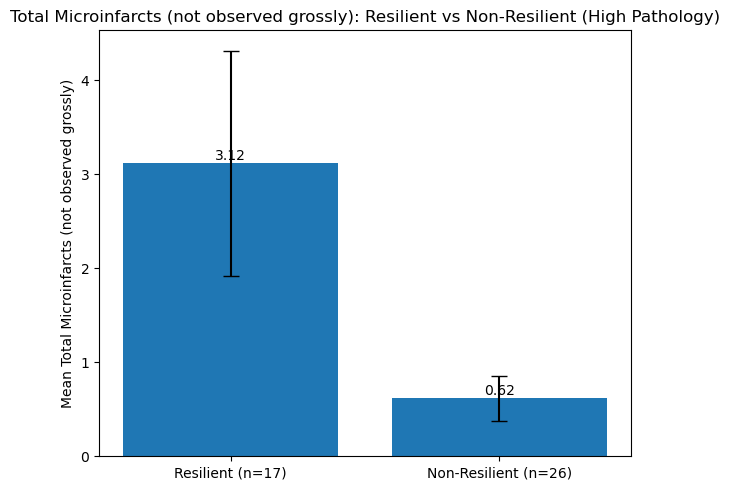

T-statistic: 2.044
P-value:     0.0565
Significant at α=0.05?  NO


In [56]:
# Means & SEMs
means = [res_vals.mean(), non_vals.mean()]
sems  = [res_vals.sem(),  non_vals.sem()]
labels = [f"Resilient (n={len(res_vals)})", f"Non-Resilient (n={len(non_vals)})"]

#2-bar plot
plt.figure(figsize=(6,5))
plt.bar(labels, means, yerr=sems, capsize=6)
plt.ylabel(f"Mean {comp_col}")
plt.title(f"{comp_col}: Resilient vs Non-Resilient (High Pathology)")
for i, m in enumerate(means):
    if not np.isnan(m):
        plt.text(i, m, f"{m:.2f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Welch's t-test
t_stat, p_val = ttest_ind(res_vals, non_vals, equal_var=False, nan_policy="omit")
alpha = 0.05
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value:     {p_val:.4f}")
print("Significant at α=0.05? ", "YES" if p_val < alpha else "NO")


^In this cohort, resilient donors actually show higher average microinfarct counts, but the difference does not meet the 0.05 threshold.

In [72]:
from scipy.stats import mannwhitneyu, levene, shapiro

# Non-parametric comparison
u_stat, p_u = mannwhitneyu(res_vals, non_vals, alternative="two-sided")
print(f"Mann–Whitney U: U={u_stat:.1f}, p={p_u:.4f}")

# Variance equality (Levene)
lev_stat, p_lev = levene(res_vals, non_vals, center='median')
print(f"Levene’s test (equal variances): stat={lev_stat:.2f}, p={p_lev:.4f}")

# Normality (Shapiro–Wilk) 
sw_res = shapiro(res_vals)
sw_non = shapiro(non_vals)
print(f"Shapiro–Wilk (Resilient): W={sw_res.statistic:.2f}, p={sw_res.pvalue:.4f}")
print(f"Shapiro–Wilk (Non-Res):   W={sw_non.statistic:.2f}, p={sw_non.pvalue:.4f}")


Mann–Whitney U: U=295.5, p=0.0365
Levene’s test (equal variances): stat=6.35, p=0.0157
Shapiro–Wilk (Resilient): W=0.66, p=0.0000
Shapiro–Wilk (Non-Res):   W=0.57, p=0.0000


4. We will relate cognition to pathology with a scatterplot and regression. We will only keep donors with Braak and MMSE

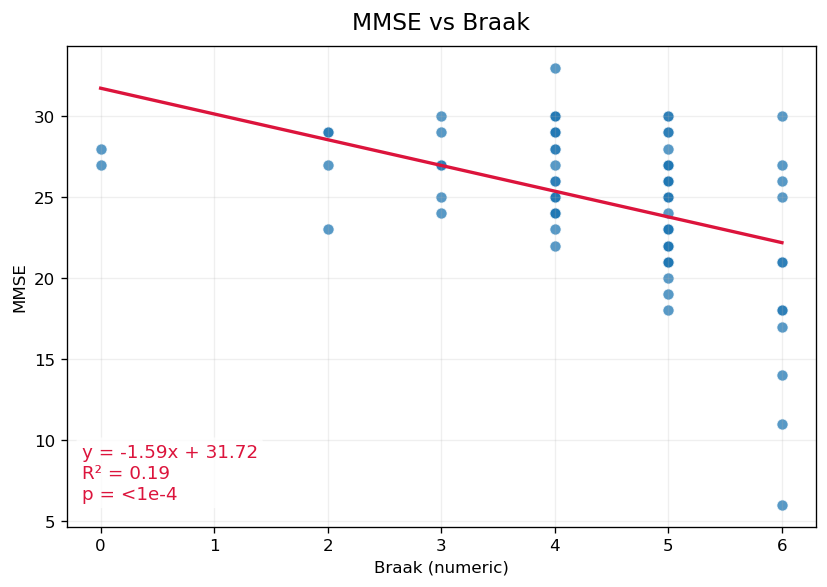

In [71]:

from scipy.stats import linregress

x = sub[braak_num].to_numpy()
y = sub[mmse_col].to_numpy()

#regression
res = linregress(x, y)
m, b = res.slope, res.intercept
r, p = res.rvalue, res.pvalue
r2 = r**2


p_text = f"{p:.4f}" if p >= 1e-4 else "<1e-4"
eq_text = f"y = {m:.2f}x + {b:.2f}\nR² = {r2:.2f}\np = {p_text}"
x_line = np.linspace(x.min(), x.max(), 100)
y_line = m * x_line + b
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)
ax.scatter(x, y, s=45, alpha=0.75, edgecolors="white", linewidths=0.6)
ax.plot(x_line, y_line, color="crimson", linewidth=2)
ax.set_title("MMSE vs Braak", fontsize=14, pad=10)
ax.set_xlabel("Braak (numeric)")
ax.set_ylabel("MMSE")
ax.grid(True, alpha=0.2)
    
ax.text(0.02, 0.05, eq_text, transform=ax.transAxes,
        ha="left", va="bottom", color="crimson", fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.8))

plt.tight_layout()
plt.show()

**Summary**

What we did:

1) Cohort framing: we limited to high-pathology donors (Braak ≥ 5, Thal ≥ 4) and split them by cognition: Resilient (MMSE ≥ 24 or MOCA ≥ 26; n=17) vs Non-Resilient (n=26).

2) Main comparison:
Outcome, Total Microinfarcts (not observed grossly).
- Welch’s t-test: t=2.044, p=0.0565 → not significant at α=0.05.
- Assumption checks: Levene p=0.0157 (variances unequal); Shapiro–Wilk both p<1e-4 (non-normal).
- Nonparametric backup (Mann–Whitney): U=295.5, p=0.0365 → significant distributional difference (resilient group tends to have more microinfarcts).
-  Results are sensitive to assumptions; direction is counter-intuitive.

3) Pathology ↔ cognition (scatter/regression).
- MMSE vs Braak: r = −0.44, R² ≈ 0.19, p < 0.0001 → higher tau stage associates with lower cognitive score; Braak alone explains ~19% of MMSE variance.

**Bottom line:**

- Across high-pathology donors, resilience does not simply equal “fewer microinfarcts” in this dataset.
- The expected macro trend holds: more tau pathology → worse cognition.


## Verify and validate your analysis: 

Our data:
- Mean total microinfarcts was higher in the Resilient group than in the Non-Resilient group. Welch’s t-test was borderline (t = 2.044, p = 0.0565). Because normality and equal-variance failed, we also ran a Mann–Whitney U, which did find a group difference (U ≈ 295.5, p = 0.0365)
- MMSE vs Braak showed a clear negative correlation (r ≈ −0.44, p < 1e−4): higher tau stage → lower MMSE.

Comparing with prior work:
- The MMSE–Braak result matches many reports: higher Braak (tau) is linked to worse cognition in autopsy cohorts and PET “Braak-like” staging models. Table 2 in [5] shows lower MMSE at higher Braak; PET studies in [6] also find worse MMSE/CDR with higher stage.
- Most studies tie microinfarcts to worse cognition and lower odds of resilience: in the ACT cohort, microinfarcts reduced the odds of being resilient (OR ≈ 0.34) [1]; in ROS, microinfarcts (especially multiple cortical ones) were linked to dementia and lower global and domain scores, independent of AD pathology [3]; a large review (>10k people) reports higher microinfarct burden in AD and vascular dementia than in non-demented controls [4].
-----> in our restricted high-pathology sample (Braak ≥ 5 and Thal ≥ 4), the Resilient group showed higher average microinfarcts. This goes against the usual direction in the literature [1,3,4].

Method choices match prior studies.
- Like [1], we compared groups with t-tests / rank-sum when needed, checked assumptions (normality and variance equality), and reported p-values with α = 0.05.
- Our use of a non-parametric test when Shapiro/Levene failed mirrors the approach in [1] (they used Wilcoxon rank-sum for medians) and is standard good practice.
- Our focus on vascular co-pathology (microinfarcts) for resilience is consistent with [1–4], and our tau–cognition result is supported by [5–6].

What we trust:
- MMSE–Braak: strong and consistent with [5–6]
- Microinfarcts: we did detect a group difference (Mann–Whitney), but the direction in our small, high-pathology slice is opposite to most reports [1,3,4].

References:

[1] Bowles, E. J. A., Crane, P. K., Walker, R. L., Chubak, J., LaCroix, A. Z., Anderson, M. L., Rosenberg, D., Keene, C. D., & Larson, E. B. (2019). Cognitive resilience to Alzheimer’s disease pathology in the human brain. Journal of Alzheimer’s Disease, 68(3), 1071–1083. https://doi.org/10.3233/JAD-180942

[2] Yao, T., Hu, B., Zhou, Y., Xie, L., Moore, K., Dworkin, J. D., Barnes, L. L., Bennett, D. A., & Yu, L. (2020). Quantifying cognitive resilience in Alzheimer’s disease: The Alzheimer’s Disease Cognitive Resilience Score. PLOS ONE, 15(11), e0241707. https://doi.org/10.1371/journal.pone.0241707

[3] Arvanitakis, Z., Leurgans, S. E., Barnes, L. L., Bennett, D. A., & Schneider, J. A. (2011). Microinfarct pathology, dementia, and cognitive systems. Stroke, 42(3), 722–727. https://doi.org/10.1161/STROKEAHA.110.595082

[4] Brundel, M., de Bresser, J., van Dillen, J. J., Kappelle, L. J., & Biessels, G. J. (2012). Cerebral microinfarcts: A systematic review of neuropathological studies. Journal of Cerebral Blood Flow & Metabolism, 32(3), 425–436. https://doi.org/10.1038/jcbfm.2011.200

[5] Malek-Ahmadi, M., Perez, S. E., Chen, K., & Mufson, E. J. (2020). Braak stage, cerebral amyloid angiopathy, and cognitive decline in early Alzheimer’s disease. Journal of Alzheimer’s Disease, 74(1), 189–197. https://doi.org/10.3233/JAD-191151

[6] Macedo, A. C., Fraga, F. J., Gonçalves, O. F., Ferreira, A. C., Santana, I., & Castelo-Branco, M. (2024). Predicting functional decline in aging and Alzheimer’s disease with PET-based Braak staging. Brain Communications, 6(2), fcae043. https://doi.org/10.1093/braincomms/fcae043

## Conclusions and Ethical Implications: 

Conclusions
- We split high‐pathology donors into Resilient (normal MMSE/MOCA) and Non-Resilient and compared total microinfarcts.
- Welch’s t-test: Resilient mean = 3.12, Non-Resilient = 0.52; p = 0.0565 → not significant at α=0.05.
- Assumption checks failed (non-normal, unequal variances), so we also ran Mann–Whitney U → p = 0.0365 (exploratory).
- Direction was unexpected: resilient donors had more microinfarcts on average. This might be noise, a sample/measurement issue, or it could hint that where/when vascular lesions occur matters.
- Across all donors, MMSE decreased with higher Braak (r ≈ −0.44, R² ≈ 0.19, p < 0.001), which supports the link between tau stage and cognition.

Ethical Implications
- I report these results carefully and don’t claim we proved cause and effect. Our stats were mixed (Welch’s t just above 0.05; Mann–Whitney below 0.05), so I call the findings preliminary. The data come from brain donors, so I acknowledge the donors and families and treat results with respect.
- For clinicians: interpret microinfarct counts with caution (until location and severity are known)
- For hospitals/health systems: it is important to invest in better microinfarct assessment.
- For society: "resilience" likely reflects many factor. It is important to communicate this uncertainty to avoid stigma.

## Limitations and Future Work: 
*(Think about the answer your analysis generated, draw conclusions related to your overarching question, and discuss the ethical implications of your conclusions.*

Limitations
- Small, uneven groups. Resilient (n=17) vs Non-Resilient (n=26) → less power and noisier estimates.
- Stats assumptions not met. Normality and equal-variance checks failed, so classic t-tests are shaky here.
- One outcome measure. We only used “total microinfarcts (not observed grossly).” This ignores where the tiny strokes are and how severe they are.
- Missing factors. We didn’t adjust for things like age at death, sex, education, APOE, brain weight, post-mortem interval, brain pH, CAA, or hippocampal sclerosis, which could influence both cognition and pathology.
- Autopsy sample. These are brain donors, not the general population. Results may not generalize to living patients

Future work
- Bigger, balanced sample. Add more donors so the two groups are closer in size and the stats are more stable.
- Adjust for confounders. Run models that include age, sex, education, APOE, CAA, hippocampal sclerosis, brain weight, etc.
- Analyze location (cortex vs deep), number of regions, and severity of microinfarcts
- Analyze more test interactions (e.g. Braak × CAA).
- Idea: visualizing where microinfarcts concentrate with a heatmap. Compare "dark" and "light" areas between resilient and not-resilient donors.

## NOTES FROM YOUR TEAM: 
*This is where our team is taking notes and recording activity.*

- finished disease background
- defined the study focus (high-pathology donors → Braak ≥ 5 and Thal ≥ 4)
- carefully followed "Have it your Way" slides to decide what statistical tests to run + did background research on t-tests (Welch's more specifically)
- added 3 tests: did bunch of background research
- polished scatter plot
- made code more concise and removed unnecessary parts
- polished summary
- kept code in Codehub.py while testing
- added comments to explain groups of code
- rewrote goal of data analysis
- finished last 3 segments: came back to polish...

## QUESTIONS FOR YOUR TA: 
*These are questions we have for our TA.*

- I have no questions or concerns for the TA right now